In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from algorithms import ga, de
from utils import repeat

In [2]:
def rosen(X):
  x, y = X
  return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

rosen_boundaries = [(-5, 5), (-5, 5)]

In [15]:

fmap = {"rand": de.mutation.rand,
       "best": de.mutation.best,
       "curr_to_best": de.mutation.curr_to_best}

X, Y = np.meshgrid(np.array(["rand", "best", "curr_to_best"]), np.array([1, 2]))
X = X.flatten()
Y = Y.flatten()

N = 30
F = 0.8
Cr = 0.8
NP = 100

de_experiments = {x: {} for x in fmap}
for x, y in tqdm(zip(X, Y)):
  print(f"X = {x}, Y = {y}")
  results = repeat(30, de.minimize, rosen, rosen_boundaries, NP, F, Cr, x=fmap[x], y=y)
  de_experiments[x][y] = np.array([list(result) for result in results], dtype=[('best_x', float, (2,)), ('fitness', float)])

0it [00:00, ?it/s]

X = rand, Y = 1


1it [00:00,  1.68it/s]

X = best, Y = 1


2it [00:01,  1.73it/s]

X = curr_to_best, Y = 1


3it [00:01,  1.77it/s]

X = rand, Y = 2


4it [00:02,  1.70it/s]

X = best, Y = 2


5it [00:02,  1.68it/s]

X = curr_to_best, Y = 2


6it [00:03,  1.73it/s]
6it [00:03,  1.73it/s]


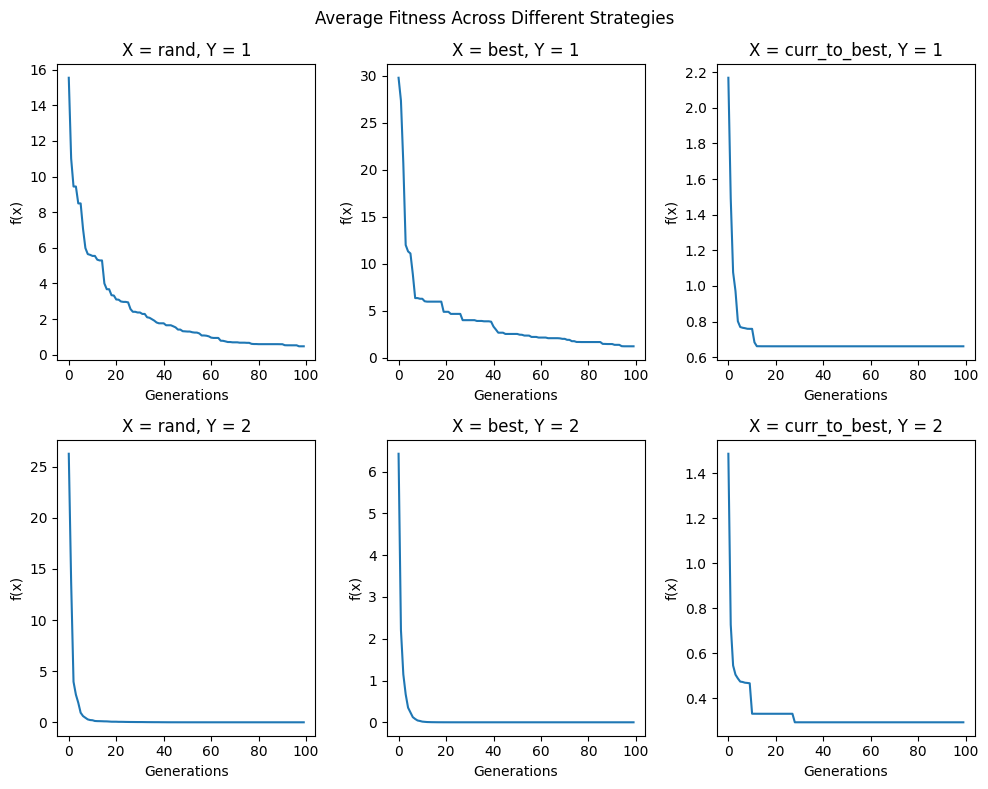

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
axs = axs.flatten()

for i, (x, y) in enumerate(zip(X, Y)):
  axs[i].plot(np.mean(de_experiments[x][y]["fitness"], axis=0))
  axs[i].set_title(f"X = {x}, Y = {y}")
  axs[i].set_xlabel("Generations")
  axs[i].set_ylabel("f(x)")

plt.suptitle("Average Fitness Across Different Strategies")
plt.tight_layout()
plt.show()

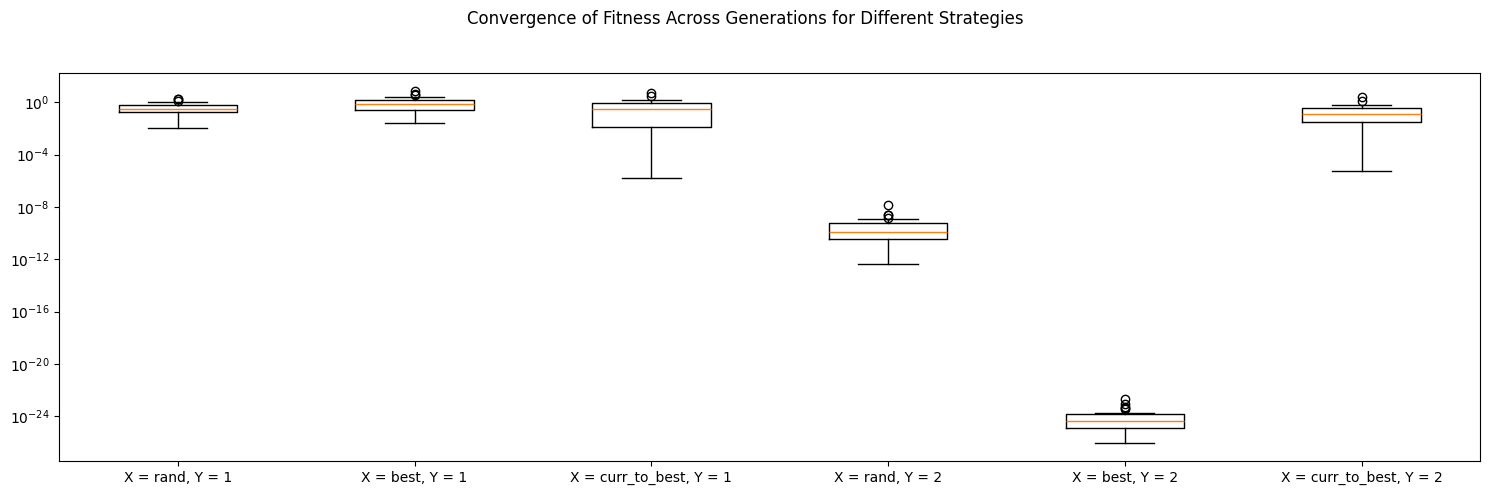

In [17]:
fig = plt.figure(figsize=(15, 5))

data = [de_experiments[x][y]["fitness"][:, 99] for x, y in zip(X, Y)]
plt.boxplot(data, labels=[f"X = {x}, Y = {y}" for x, y in zip(X, Y)])
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

In [18]:
fmap = {"roullete": ga.selection.roullete, 
        "tournament": ga.selection.tournament,
        "uniform": ga.mutation.uniform,
        "gaussian": ga.mutation.gaussian}

experiment_selection = ["roullete", "tournament"]
experiment_mutation = ["uniform", "gaussian"]

experiments_strats = np.meshgrid(experiment_selection, experiment_mutation)
S, M = experiments_strats
S = S.flatten()
M = M.flatten()

Cr = 0.8
F = 0.05
NP = 50
repetitions = 30

ga_experiments = {}
for selection, mutation in tqdm(zip(S, M)):
  print(f"Selection = {selection}, Mutation = {mutation}")
  results = repeat(repetitions, ga.minimize, rosen, rosen_boundaries, NP, F, Cr, selection_function=fmap[selection], mutation_function=fmap[mutation])
  ga_experiments[(selection, mutation)] = np.array([list(result) for result in results], dtype=[('best_x', float, (2,)), ('fitness', float)])

0it [00:00, ?it/s]

Selection = roullete, Mutation = uniform


1it [00:01,  1.71s/it]

Selection = tournament, Mutation = uniform


2it [00:02,  1.34s/it]

Selection = roullete, Mutation = gaussian


3it [00:04,  1.48s/it]

Selection = tournament, Mutation = gaussian


4it [00:05,  1.38s/it]
4it [00:05,  1.38s/it]


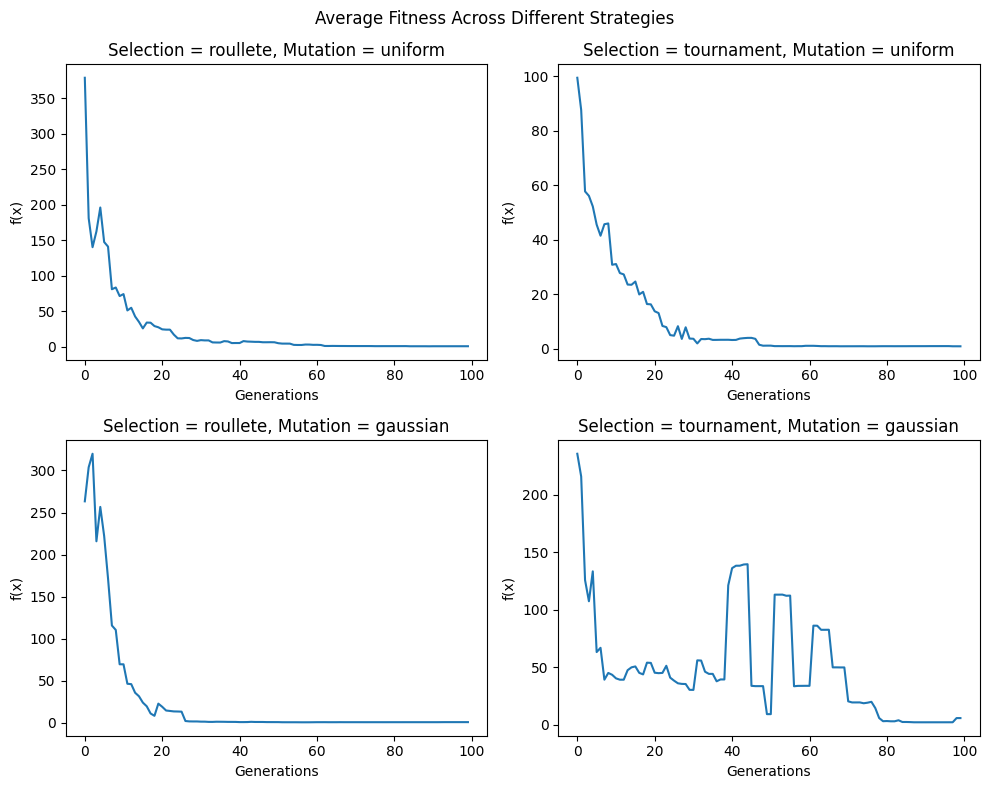

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, (selection, mutation) in enumerate(zip(S, M)):
  axs[i].plot(np.mean(ga_experiments[(selection, mutation)]["fitness"], axis=0))
  axs[i].set_title(f"Selection = {selection}, Mutation = {mutation}")
  axs[i].set_xlabel("Generations")
  axs[i].set_ylabel("f(x)")

plt.suptitle("Average Fitness Across Different Strategies")
plt.tight_layout()
plt.show()

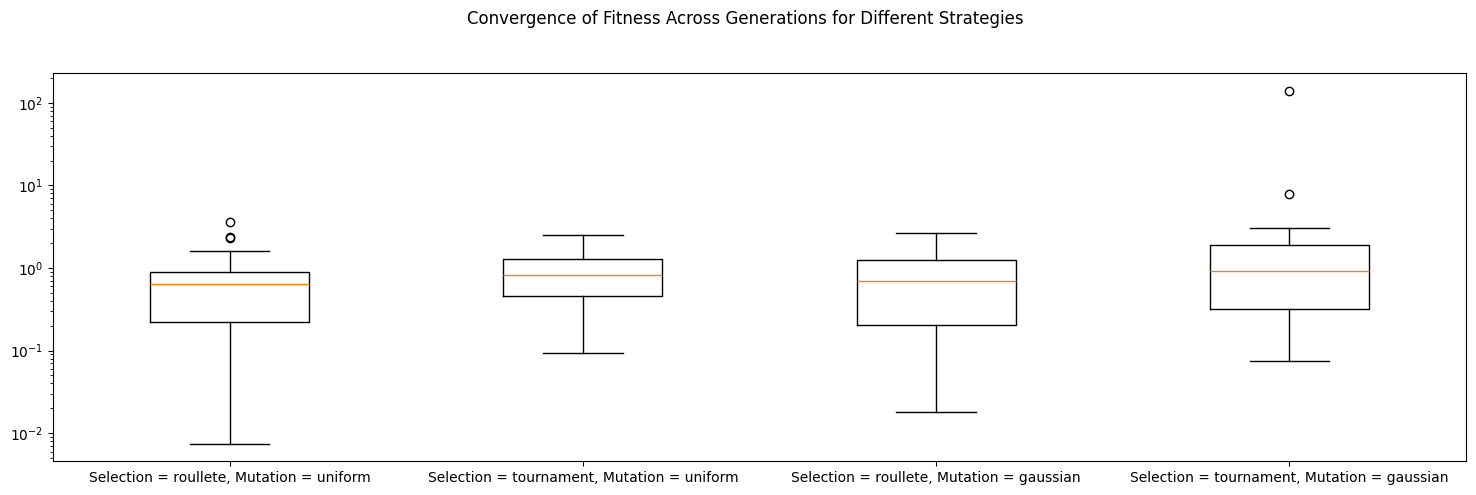

In [20]:
fig = plt.figure(figsize=(15, 5))

data = [ga_experiments[(x, y)]["fitness"][:, 99] for x, y in zip(S, M)]
plt.boxplot(data, labels=[f"Selection = {x}, Mutation = {y}" for x, y in zip(S, M)])
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

In [10]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.operators.sampling.lhs import LHS

class SavePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.data = []

    def notify(self, algorithm):
        # append the deep copy of current population to data list
        best_idx = np.argmin(algorithm.pop.get("F"))
        best_x = np.float32(algorithm.pop.get("X")[best_idx])
        best_f = np.float32(algorithm.pop.get("F")[best_idx])
        self.data.append((best_x, best_f))

callback = SavePopulationCallback()

problem = get_problem("rosenbrock", n_var=2)

pymoo_ga = GA(
    pop_size=100,
    eliminate_duplicates=True,
    max_gen=100)

pymoo_de = DE(
    pop_size=100,
    sampling=LHS(),
    variant="DE/rand/1/bin",
    CR=0.3,
    dither="vector",
    jitter=False
)

In [24]:
#@title Run Pymoo GA

pymoo_ga_experiments = []
for i in range(30):
  callback = SavePopulationCallback()
  res = minimize(problem,
               pymoo_ga,
               seed=1,
               callback=callback)
  pymoo_ga_experiments.append(callback.data)
pymoo_ga_experiments = np.array(pymoo_ga_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])

/var/folders/qk/qhpk8_352d1gw4g1s3r0mlrm0000gn/T/ipykernel_66744/4172191527.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pymoo_ga_experiments = np.array(pymoo_ga_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])


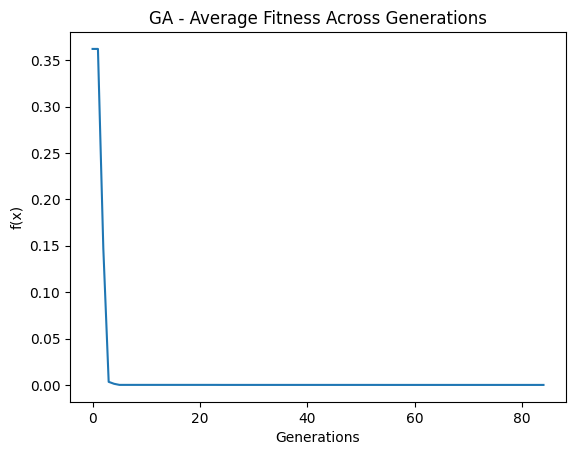

In [25]:
plt.plot(np.mean(pymoo_ga_experiments["fitness"], axis=0))
plt.title("GA - Average Fitness Across Generations")
plt.xlabel("Generations")
plt.ylabel("f(x)")
plt.show()

In [26]:
#@title Run Pymoo DE

pymoo_de_experiments = []
for i in range(30):
  callback = SavePopulationCallback()
  res = minimize(problem,
               pymoo_de,
               seed=1,
               callback=callback)
  pymoo_de_experiments.append(callback.data)
pymoo_de_experiments = np.array(pymoo_de_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])

/var/folders/qk/qhpk8_352d1gw4g1s3r0mlrm0000gn/T/ipykernel_66744/1135588601.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pymoo_de_experiments = np.array(pymoo_de_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])


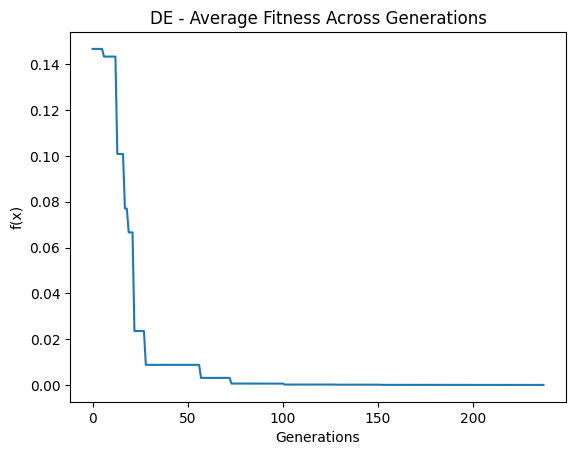

In [27]:
plt.plot(np.mean(pymoo_de_experiments["fitness"], axis=0))
plt.title("DE - Average Fitness Across Generations")
plt.xlabel("Generations")
plt.ylabel("f(x)")
plt.show()

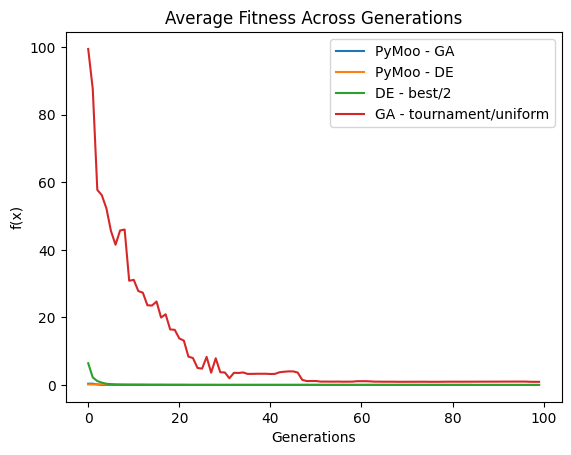

In [36]:
plt.plot(np.mean(pymoo_ga_experiments["fitness"], axis=0)[:100], label="PyMoo - GA")
plt.plot(np.mean(pymoo_de_experiments["fitness"], axis=0)[:100], label="PyMoo - DE")
plt.plot(np.mean(de_experiments["best"][2]["fitness"], axis=0), label="DE - best/2")
plt.plot(np.mean(ga_experiments[("tournament", "uniform")]["fitness"], axis=0), label="GA - tournament/uniform")

plt.title("Average Fitness Across Generations")
plt.xlabel("Generations")
plt.ylabel("f(x)")
# plt.yscale('log')
plt.legend()
plt.show()

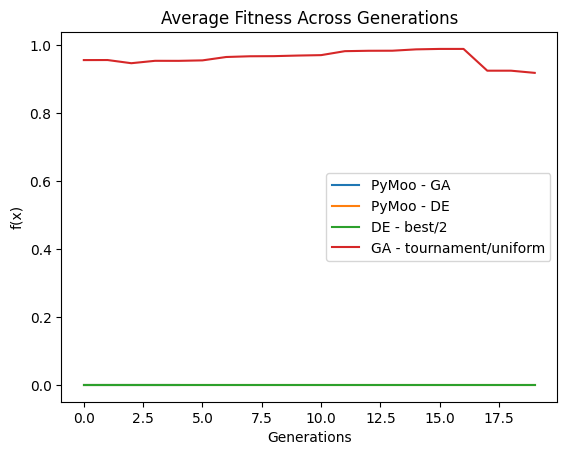

In [37]:
plt.plot(np.mean(pymoo_ga_experiments["fitness"], axis=0)[80:100], label="PyMoo - GA")
plt.plot(np.mean(pymoo_de_experiments["fitness"], axis=0)[80:100], label="PyMoo - DE")
plt.plot(np.mean(de_experiments["best"][2]["fitness"], axis=0)[80:100], label="DE - best/2")
plt.plot(np.mean(ga_experiments[("tournament", "uniform")]["fitness"], axis=0)[80:100], label="GA - tournament/uniform")

plt.title("Average Fitness Across Generations")
plt.xlabel("Generations")
plt.ylabel("f(x)")
# plt.yscale('log')
plt.legend()
plt.show()